In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from nbconvert import PythonExporter
import os
from tqdm import tqdm
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, log_loss
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks, regularizers
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
from tensorflow import one_hot, cast, float32
from keras.applications.xception import preprocess_input
from tensorflow.data import Dataset, AUTOTUNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2025-09-08 12:40:38.260622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757335238.633161      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757335238.742122      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### Loading data ####

In [2]:
# adding the images, labels, styles
file_path = "/kaggle/input/wikiart-all-artpieces/wikiart_art_pieces.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,genre,movement,tags,url,img,file_name
0,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch'...",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,0-ravenna-cappella-arcivescovile-166.jpg
1,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Byzantinearchitecture', 'Arch']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,1-ravenna-cappella-arcivescovile-167.jpg
2,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Prophet', 'History']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,2-ravenna-cappella-arcivescovile-168.jpg
3,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,3-ravenna-cappella-arcivescovile-169.jpg
4,Byzantine Mosaics,Early Byzantine (c. 330–750),religious painting,Byzantine Art,"['Holyplaces', 'Prophet']",https://www.wikiart.org/en/byzantine-mosaics/e...,https://uploads2.wikiart.org/00211/images/byza...,4-ravenna-cappella-arcivescovile-171.jpg


In [3]:
df.shape

(176436, 8)

In [4]:
def filter_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """clean the dataframe to keep categories wanted"""

    #lists :
    styles_to_keep = ['Orientalism', 'Neoclassicism', 'Naturalism', 'Romanticism', 'Academicism', 'Neo-Rococo', 'Kitsch', 'Realism', 'Impressionism', 'Expressionism', 'Japonism', 'Magic Realism', 'Symbolism', 'Costumbrismo', 'Biedermeier', 'Luminism', 'Ink and wash painting', 'Naïve Art (Primitivism)', 'Art Nouveau (Modern)', 'Divisionism', 'Social Realism', 'Tonalism', 'Post-Impressionism', 'Pointillism', 'Ukiyo-e', 'American Realism', 'Socialist Realism', 'Fauvism', 'Cubism', 'Abstract Art', 'Precisionism', 'Figurative Expressionism', 'Existential Art', 'Surrealism', 'New Realism', 'Neo-baroque', 'Abstract Expressionism', 'Neo-Romanticism', 'Neo-Impressionism', 'Cloisonnism', 'Synthetism', 'Regionalism', 'Orphism', 'Art Deco', 'Neo-Expressionism', 'Fantasy Art', 'New Medievialism', 'Neo-Byzantine', 'Lyrical Abstraction', 'New Ink Painting', 'Verism', 'Contemporary Realism', 'Color Field Painting', 'Art Brut', 'Outsider art', 'Cubo-Expressionism', 'Pop Art', 'Geometric', 'Art Singulier', 'Action painting', 'Constructivism', 'Neoplasticism', 'Intimism', 'Dada', 'Analytical Cubism', 'Synthetic Cubism', 'Muralism', 'Futurism', 'Cubo-Futurism', 'Tachisme', 'Modernismo', 'Metaphysical art', 'Excessivism', 'Classical Realism', 'Severe Style', 'Miserablism', 'Art Informel', 'Neo-Pop Art', 'Native Art', 'Transavantgarde', 'Contemporary', 'Conceptual Art', 'Light and Space', 'Junk Art', 'Shin-hanga', 'Hard Edge Painting', 'Neo-Figurative Art', 'Purism', 'Tubism', 'Suprematism', 'Concretism', 'Analytical\xa0Realism', 'Mechanistic Cubism', 'Neo-Suprematism', 'Automatic Painting', 'Op Art', 'Minimalism', 'Post-Minimalism', 'Post-Painterly Abstraction', 'Neo-Concretism', 'Lettrism', 'Kinetic Art', 'New European Painting', 'P&D (Pattern and Decoration)', 'New Casualism', 'Neo-Dada', 'Spectralism', 'Rayonism', 'Synchromism', 'Modernism', 'Feminist Art', 'Transautomatism', 'Fantastic Realism', 'Photorealism', 'Hyper-Realism', 'Nouveau Réalisme', 'Postcolonial art', 'Sots Art', 'Indian Space painting', 'Zen', 'Spatialism', 'Cartographic Art', 'Superflat', 'Mail Art', 'Neo-Minimalism', 'Fiber art', 'Street art', 'Neo-Geo', 'Maximalism', 'Queer art', 'Digital Art', 'Cyber Art', 'Poster Art Realism', 'Hyper-Mannerism (Anachronism)', 'Confessional Art', 'Neo-Orthodoxism', 'Graffiti Art', 'Lowbrow Art', 'Stuckism']
    genres_to_drop = ['sketch and study', 'sculpture', 'design', 'installation', 'no genre', 'photo', 'poster', 'caricature', 'graffiti', 'advertisement', 'utensil', 'veduta', 'performance', 'capriccio', 'mural', 'bird-and-flower painting', 'digital', 'architecture', 'mobile', 'miniature', 'tapestry', 'pastorale', 'furniture', 'calligraphy', 'shan shui', 'mosaic', 'vanitas', 'jewelry', 'pin-up', 'video', "trompe-l'œil", 'panorama', 'stabile', 'augmented reality', 'quadratura', 'object', "artist's book", 'ornament', 'animation', 'tronie']

    #Clean the styles
    df_cleaned_styles = df[df['style'].isin(styles_to_keep)]

    #Clean the movement
    df_cleaned_styles_movements = df_cleaned_styles[df_cleaned_styles['movement'].isin(styles_to_keep)]

    #Create a copy of the dataframe and split the genres to a list (multiple values possibles)
    df_cleaned_styles_movements_copy = df_cleaned_styles_movements.copy()
    df_cleaned_styles_movements_copy['genre_list'] = df_cleaned_styles_movements_copy['genre'].str.split(',\s*', regex=True)
    df_cleaned_styles_movements_copy = df_cleaned_styles_movements_copy.drop(columns='genre')

    # Clean the genres (chosed the ones to drop)
    df_cleaned_styles_movement_genres = df_cleaned_styles_movements_copy[df_cleaned_styles_movements_copy['genre_list'].apply(
        lambda x: all(genre not in genres_to_drop for genre in x) if isinstance(x, list) else True
    )]

    df_filtered = df_cleaned_styles_movement_genres.drop_duplicates(subset=['img'], keep='first')
    df_filtered = df_filtered.set_index("file_name", drop=False)
    return df_filtered

In [5]:
df = filter_dataframe(df)

In [6]:
df.shape

(115055, 8)

In [7]:
df['style'].value_counts()

style
Impressionism         15301
Romanticism           13208
Realism               12730
Expressionism         10263
Post-Impressionism     7166
                      ...  
Geometric                 4
New Ink Painting          3
Kinetic Art               2
Rayonism                  1
Shin-hanga                1
Name: count, Length: 135, dtype: int64

In [8]:
counts = df['style'].value_counts()
rare_styles = counts[counts < 200]
print(rare_styles)

style
Neo-baroque          199
Classical Realism    198
Constructivism       190
Street art           188
Muralism             186
                    ... 
Geometric              4
New Ink Painting       3
Kinetic Art            2
Rayonism               1
Shin-hanga             1
Name: count, Length: 79, dtype: int64


In [9]:
df_filtered = df[df['style'].map(df['style'].value_counts()) > 200]

In [10]:
df_filtered.shape

(109618, 8)

In [11]:
df_filtered['style'].value_counts()

style
Impressionism                 15301
Romanticism                   13208
Realism                       12730
Expressionism                 10263
Post-Impressionism             7166
Surrealism                     6045
Symbolism                      4632
Abstract Expressionism         3457
Neoclassicism                  2306
Cubism                         2130
Pop Art                        2072
Art Nouveau (Modern)           1967
Art Informel                   1666
Magic Realism                  1552
Abstract Art                   1445
Contemporary Realism           1422
Neo-Expressionism              1339
Minimalism                     1223
Color Field Painting           1222
Orientalism                    1142
Lyrical Abstraction            1091
Fauvism                        1056
Naïve Art (Primitivism)         971
Neo-Impressionism               961
Academicism                     892
Op Art                          757
Naturalism                      707
Neo-Romanticism       

In [12]:
num_style = df_filtered['style'].nunique()
num_style

56

In [13]:
df_filtered['style'].unique()

array(['Neoclassicism', 'Orientalism', 'Romanticism', 'Academicism',
       'Kitsch', 'Realism', 'Naturalism', 'Impressionism',
       'Expressionism', 'Magic Realism', 'Symbolism', 'Biedermeier',
       'Luminism', 'Naïve Art (Primitivism)', 'Art Nouveau (Modern)',
       'Divisionism', 'Social Realism', 'Tonalism', 'Post-Impressionism',
       'Socialist Realism', 'Fauvism', 'Cubism', 'Abstract Art',
       'Precisionism', 'Figurative Expressionism', 'Surrealism',
       'Abstract Expressionism', 'Neo-Romanticism', 'Neo-Impressionism',
       'Regionalism', 'Art Deco', 'Neo-Expressionism',
       'Lyrical Abstraction', 'Contemporary Realism',
       'Color Field Painting', 'Pop Art', 'Dada', 'Synthetic Cubism',
       'Futurism', 'Tachisme', 'Metaphysical art', 'Art Informel',
       'Neo-Pop Art', 'Native Art', 'Transavantgarde', 'Contemporary',
       'Hard Edge Painting', 'Concretism', 'Op Art', 'Minimalism',
       'Conceptual Art', 'Post-Painterly Abstraction',
       'New Europ

In [14]:
df = df_filtered.copy()

In [15]:
df.shape

(109618, 8)

#### Loading and resize images ####

In [16]:
#create full path column in df
df["filepath"] = df["file_name"].apply(
    lambda x: os.path.join("/kaggle/input/wikiart-all-artpieces/wikiart/wikiart", x)
)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,filepath
file_name,,,,,,,,,
28564-the-waterfalls-at-tivoli.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Nature', 'Naturallandscape', 'Atmosphericphe...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads5.wikiart.org/00128/images/clau...,28564-the-waterfalls-at-tivoli.jpg,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28565-the-bridge-and-the-castel-sant-angelo-in-rome.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Waterway', 'Watercraftrowing', 'Gondola', 'B...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads8.wikiart.org/00128/images/clau...,28565-the-bridge-and-the-castel-sant-angelo-in...,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28566-villa-at-caprarola.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Sky', 'Ruralarea', 'Highland', 'Hill']",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads8.wikiart.org/00128/images/clau...,28566-villa-at-caprarola.jpg,[landscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28567-vedi-titolo.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,"['Sky', 'Cloud', 'Horizon', 'Atmosphere', 'Eco...",https://www.wikiart.org/en/claude-joseph-verne...,https://uploads1.wikiart.org/00128/images/clau...,28567-vedi-titolo.jpg,[cloudscape],/kaggle/input/wikiart-all-artpieces/wikiart/wi...
28568-night-a-port-in-the-moonlight-1748.jpg,Claude-Joseph Vernet,Neoclassicism,Neoclassicism,['Sky'],https://www.wikiart.org/en/claude-joseph-verne...,https://uploads0.wikiart.org/00259/images/clau...,28568-night-a-port-in-the-moonlight-1748.jpg,[marina],/kaggle/input/wikiart-all-artpieces/wikiart/wi...


#### Define X and y ####

In [17]:
X = df["filepath"]
y = df['style']

In [18]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (109618,)
y shape: (109618,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

#### Encode labels ####

In [20]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Create tensorflow dataset

In [21]:
NUM_CLASSES = len(le.classes_)
NUM_CLASSES

56

In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [23]:
def is_valid_image(path):
    """Retourne True si l'image peut être décodée, False sinon"""
    try:
        img = read_file(path)
        decode_jpeg(img, channels=3)
        return True
    except:
        return False

def process_image(path, label):
    """Lit, redimensionne, normalise l'image et encode le label en one-hot"""
    img = read_file(path)
    img = decode_jpeg(img, channels=3)
    img = resize(img, IMG_SIZE)
    img = preprocess_input(img)
    
    label_one_hot = one_hot(label, depth=NUM_CLASSES)
    label_one_hot = cast(label_one_hot, float32)
    
    return img, label_one_hot

def filter_valid_images(paths, labels):
    """Filtre les images corrompues et retourne les listes valides"""
    valid_paths, valid_labels = [], []
    invalid_paths = []
    
    for p, l in zip(paths, labels):
        if is_valid_image(p):
            valid_paths.append(p)
            valid_labels.append(l)
        else:
            invalid_paths.append(p)
    
    print(f"⚠️ Images invalides : {len(invalid_paths)}")
    if invalid_paths:
        print(invalid_paths[:10])  # montrer les premières images corrompues
    
    return valid_paths, valid_labels

In [24]:
# filter valid images
X_train_valid, y_train_valid = filter_valid_images(X_train, y_train_encoded)
X_test_valid, y_test_valid = filter_valid_images(X_test, y_test_encoded)

I0000 00:00:1757335259.657376      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757335259.658030      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


⚠️ Images invalides : 1
['/kaggle/input/wikiart-all-artpieces/wikiart/wikiart/35889-screenshot-2021-12-21-152829.png']
⚠️ Images invalides : 1
['/kaggle/input/wikiart-all-artpieces/wikiart/wikiart/118309-ambroise-vollard.jpg']


In [25]:
# Create tensorflow dataset secured
train_dataset = Dataset.from_tensor_slices((X_train_valid, y_train_valid))
train_dataset = train_dataset.map(process_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = Dataset.from_tensor_slices((X_test_valid, y_test_valid))
val_dataset = val_dataset.map(process_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# define model

In [26]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [29]:
def load_model():
    input_shape = (224, 224, 3)
    model = Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    return model


In [36]:
model = load_model()
model = set_nontrainable_layers(model)
model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [37]:
def add_last_layers(model, NUM_CLASSES):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)

    # Remplacer Flatten par GlobalAveragePooling2D pour réduire drastiquement les paramètres
    gap = layers.GlobalAveragePooling2D()(base_model.output)

    # Couche dense plus compacte + Dropout
    dense1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(gap)
    drop1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(drop1)
    drop2 = layers.Dropout(0.3)(dense2)

    # Couche finale de classification
    prediction_layer = layers.Dense(NUM_CLASSES, activation='softmax')(drop2)

    # On reconstruit le modèle avec l'API fonctionnelle
    model = models.Model(inputs=base_model.input, outputs=prediction_layer)

    return model

In [38]:
model = add_last_layers(model, NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_24[0][0]    

 Total params: 21,426,144 (81.73 MB)

 Trainable params: 564,664 (2.15 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [41]:
def build_model(NUM_CLASSES):
    # $CHALLENGIFY_BEGIN
    model = load_model()
    model = add_last_layers(model, NUM_CLASSES)

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [42]:
model = build_model(NUM_CLASSES)

#### Model checkpoint ####

In [43]:
### CHANGE THE NAME WITH THE NAME OF THE MODEL YOU TRIED AND NUMBER OF IMAGES
model_checkpoint = callbacks.ModelCheckpoint("/kaggle/working/Xception_callbacks_alldata.keras", monitor='val_loss', verbose=0, save_best_only=True)

#### ReduceLROnPlateau ####

In [44]:
#Reduce the learning rate when the model stops improving
#lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0)
#exponential =

#### EarlyStopping ####

In [45]:
es = EarlyStopping(monitor = 'val_loss',
                   patience = 10,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=100,
                    callbacks=[es, model_checkpoint])

Epoch 1/100


I0000 00:00:1757337023.768881      98 service.cc:148] XLA service 0x7cb7a8004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757337023.770597      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757337023.770621      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757337024.912873      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-08 13:10:40.950871: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[64,2048,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1536,7,7]{3,2,1,0}, f32[2048,1536,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","w

 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.1440 - loss: 4.0603

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 521s 411ms/step - accuracy: 0.1767 - loss: 3.8251 - val_accuracy: 0.3096 - val_loss: 3.0591
Epoch 2/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.2663 - loss: 3.1577

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.2758 - loss: 3.1167 - val_accuracy: 0.3486 - val_loss: 2.7837
Epoch 3/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3089 - loss: 2.8901

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.3119 - loss: 2.8726 - val_accuracy: 0.3642 - val_loss: 2.6440
Epoch 4/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 273ms/step - accuracy: 0.3273 - loss: 2.7443

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3294 - loss: 2.7357 - val_accuracy: 0.3728 - val_loss: 2.5594
Epoch 5/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3380 - loss: 2.6503

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.3407 - loss: 2.6413 - val_accuracy: 0.3767 - val_loss: 2.4860
Epoch 6/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3527 - loss: 2.5701

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3541 - loss: 2.5613 - val_accuracy: 0.3847 - val_loss: 2.4331
Epoch 7/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.3588 - loss: 2.5015

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3600 - loss: 2.4979 - val_accuracy: 0.3872 - val_loss: 2.3922
Epoch 8/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 273ms/step - accuracy: 0.3610 - loss: 2.4575

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3636 - loss: 2.4526 - val_accuracy: 0.3901 - val_loss: 2.3577
Epoch 9/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 273ms/step - accuracy: 0.3713 - loss: 2.4062

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3731 - loss: 2.4058 - val_accuracy: 0.3935 - val_loss: 2.3232
Epoch 10/100
 501/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3762 - loss: 2.3796

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.3783 - loss: 2.3764 - val_accuracy: 0.3952 - val_loss: 2.3068
Epoch 11/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.3843 - loss: 2.3452

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 468s 389ms/step - accuracy: 0.3833 - loss: 2.3430 - val_accuracy: 0.3945 - val_loss: 2.2874
Epoch 12/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.3847 - loss: 2.3120

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3866 - loss: 2.3099 - val_accuracy: 0.3996 - val_loss: 2.2695
Epoch 13/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3925 - loss: 2.2984

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.3939 - loss: 2.2938 - val_accuracy: 0.3993 - val_loss: 2.2593
Epoch 14/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3924 - loss: 2.2781

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.3936 - loss: 2.2741 - val_accuracy: 0.4011 - val_loss: 2.2414
Epoch 15/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.3948 - loss: 2.2492

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.3971 - loss: 2.2475 - val_accuracy: 0.4015 - val_loss: 2.2318
Epoch 16/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.3973 - loss: 2.2335

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.3988 - loss: 2.2312 - val_accuracy: 0.4019 - val_loss: 2.2254
Epoch 17/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4024 - loss: 2.2141

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4026 - loss: 2.2148 - val_accuracy: 0.4045 - val_loss: 2.2206
Epoch 18/100
 501/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4036 - loss: 2.2054

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4057 - loss: 2.2026 - val_accuracy: 0.4086 - val_loss: 2.2118
Epoch 19/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.4065 - loss: 2.1856

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4080 - loss: 2.1861 - val_accuracy: 0.4080 - val_loss: 2.2056
Epoch 20/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4143 - loss: 2.1752

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 465s 387ms/step - accuracy: 0.4140 - loss: 2.1746 - val_accuracy: 0.4093 - val_loss: 2.2073
Epoch 21/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4127 - loss: 2.1716

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4140 - loss: 2.1685 - val_accuracy: 0.4088 - val_loss: 2.1956
Epoch 22/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4178 - loss: 2.1501

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4185 - loss: 2.1501 - val_accuracy: 0.4088 - val_loss: 2.1904
Epoch 23/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4159 - loss: 2.1403

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4173 - loss: 2.1419 - val_accuracy: 0.4099 - val_loss: 2.1901
Epoch 24/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4229 - loss: 2.1314

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4226 - loss: 2.1301 - val_accuracy: 0.4114 - val_loss: 2.1875
Epoch 25/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4220 - loss: 2.1299

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4229 - loss: 2.1278 - val_accuracy: 0.4115 - val_loss: 2.1866
Epoch 26/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4240 - loss: 2.1206

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4261 - loss: 2.1175 - val_accuracy: 0.4086 - val_loss: 2.1921
Epoch 27/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4252 - loss: 2.1084

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4284 - loss: 2.1071 - val_accuracy: 0.4132 - val_loss: 2.1770
Epoch 28/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4286 - loss: 2.1043

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4301 - loss: 2.1013 - val_accuracy: 0.4145 - val_loss: 2.1768
Epoch 29/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4309 - loss: 2.0881

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4315 - loss: 2.0898 - val_accuracy: 0.4140 - val_loss: 2.1782
Epoch 30/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4312 - loss: 2.0850

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4335 - loss: 2.0840 - val_accuracy: 0.4125 - val_loss: 2.1807
Epoch 31/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4377 - loss: 2.0700

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4381 - loss: 2.0714 - val_accuracy: 0.4160 - val_loss: 2.1732
Epoch 32/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4403 - loss: 2.0701

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 467s 388ms/step - accuracy: 0.4405 - loss: 2.0697 - val_accuracy: 0.4162 - val_loss: 2.1732
Epoch 33/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4402 - loss: 2.0624

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4412 - loss: 2.0610 - val_accuracy: 0.4145 - val_loss: 2.1771
Epoch 34/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4415 - loss: 2.0520

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4432 - loss: 2.0528 - val_accuracy: 0.4152 - val_loss: 2.1748
Epoch 35/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4492 - loss: 2.0447

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4482 - loss: 2.0465 - val_accuracy: 0.4164 - val_loss: 2.1745
Epoch 36/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4454 - loss: 2.0529

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4473 - loss: 2.0473 - val_accuracy: 0.4172 - val_loss: 2.1744
Epoch 37/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:09 272ms/step - accuracy: 0.4488 - loss: 2.0328

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 468s 388ms/step - accuracy: 0.4497 - loss: 2.0346 - val_accuracy: 0.4188 - val_loss: 2.1722
Epoch 38/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4536 - loss: 2.0258

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4526 - loss: 2.0273 - val_accuracy: 0.4168 - val_loss: 2.1733
Epoch 39/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4568 - loss: 2.0238

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4560 - loss: 2.0247 - val_accuracy: 0.4177 - val_loss: 2.1767
Epoch 40/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4540 - loss: 2.0187

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4556 - loss: 2.0196 - val_accuracy: 0.4167 - val_loss: 2.1806
Epoch 41/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4558 - loss: 2.0139

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4583 - loss: 2.0114 - val_accuracy: 0.4182 - val_loss: 2.1790
Epoch 42/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4620 - loss: 2.0105

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4606 - loss: 2.0104 - val_accuracy: 0.4197 - val_loss: 2.1751
Epoch 43/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 274ms/step - accuracy: 0.4606 - loss: 1.9971

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4611 - loss: 1.9977 - val_accuracy: 0.4182 - val_loss: 2.1825
Epoch 44/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4656 - loss: 2.0004

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4657 - loss: 1.9969 - val_accuracy: 0.4208 - val_loss: 2.1820
Epoch 45/100
 495/1199 ━━━━━━━━━━━━━━━━━━━━ 3:19 284ms/step - accuracy: 0.4673 - loss: 1.9878

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 471s 392ms/step - accuracy: 0.4664 - loss: 1.9867 - val_accuracy: 0.4212 - val_loss: 2.1823
Epoch 46/100
 501/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4694 - loss: 1.9876

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 387ms/step - accuracy: 0.4695 - loss: 1.9855 - val_accuracy: 0.4206 - val_loss: 2.1807
Epoch 47/100
 502/1199 ━━━━━━━━━━━━━━━━━━━━ 3:10 273ms/step - accuracy: 0.4658 - loss: 1.9867

Corrupt JPEG data: 4015 extraneous bytes before marker 0xe2


1199/1199 ━━━━━━━━━━━━━━━━━━━━ 466s 388ms/step - accuracy: 0.4679 - loss: 1.9830 - val_accuracy: 0.4202 - val_loss: 2.1824
Epoch 47: early stopping
Restoring model weights from the end of the best epoch: 37.


In [46]:
model.save("/kaggle/working/model_Xception_alldata.keras")

#### Evaluating the model ####

In [47]:
model.evaluate(val_dataset, return_dict=True)

514/514 ━━━━━━━━━━━━━━━━━━━━ 137s 267ms/step - accuracy: 0.4174 - loss: 2.1904


{'accuracy': 0.4188231825828552, 'loss': 2.172241449356079}

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

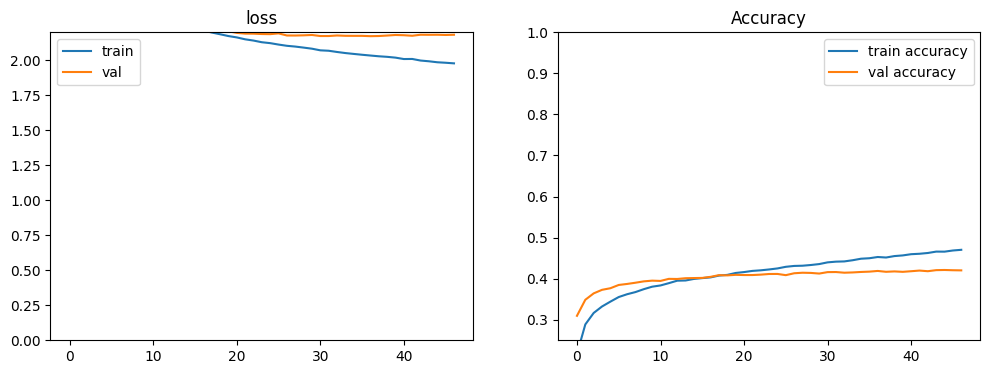

In [48]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)

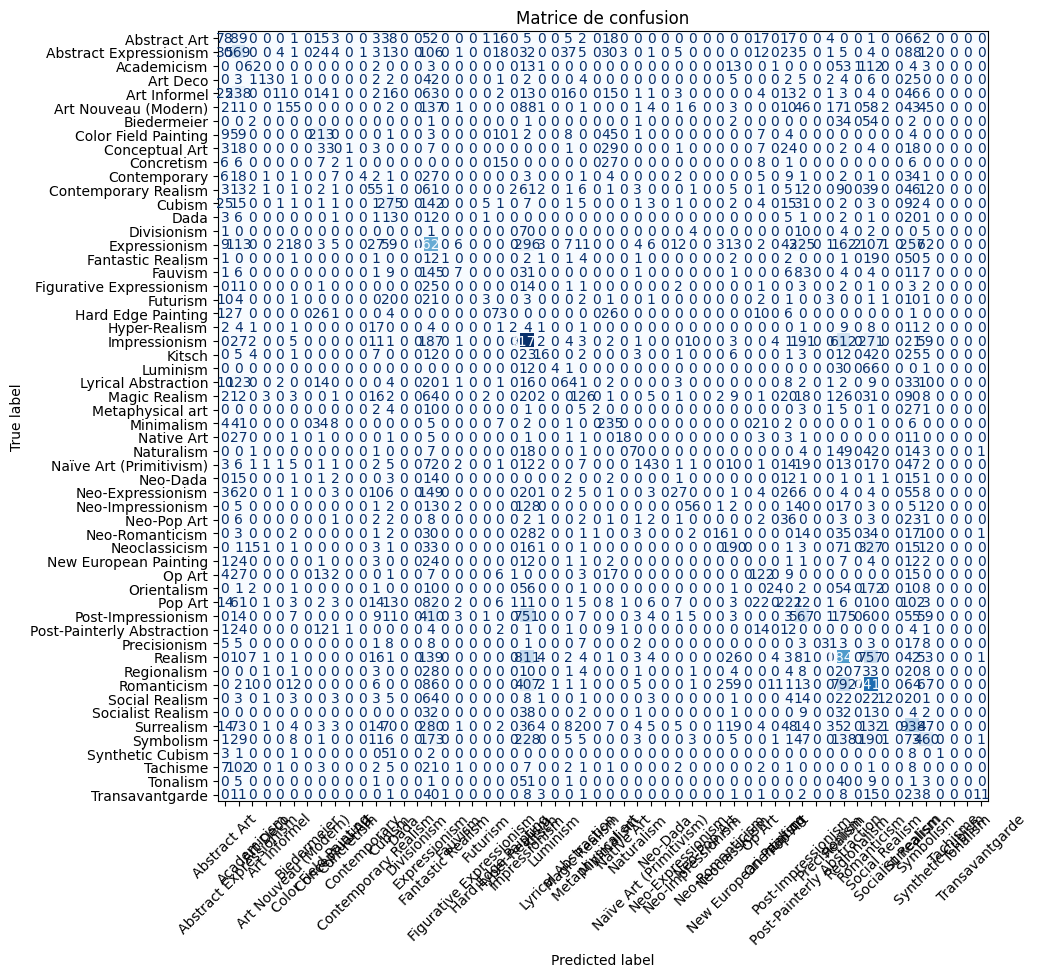

In [49]:
# 1. Prédictions sur tout le val_dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # labels vrais
    y_pred.extend(np.argmax(preds, axis=1))            # labels prédits

# 2. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# 3. Affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca(), colorbar=False)
plt.title("Matrice de confusion")
plt.show()


#### Testing ####

In [50]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [51]:
def prepare_image(path, target_size=(224, 224)):
    img = read_file(path)
    img = decode_jpeg(img, channels=3)
    img = resize(img, target_size)
    img = preprocess_input(img)
    return np.expand_dims(img.numpy(), axis=0)  # batch de 1 image

pred_labels = []
preds_all = []

# Boucle sur tes images
for path in images_paths:
    img_batch = prepare_image(path)
    preds = model.predict(img_batch, verbose=0)
    
    pred_idx = np.argmax(preds[0])
    pred_label = le.classes_[pred_idx]
    
    pred_labels.append(pred_label)
    preds_all.append(preds[0])

# Affichage compact
for img_name, label, pred in zip(images_paths, pred_labels, preds_all):
    print(f"{img_name.split('/')[-1]} : {label} ({pred.max():.2f})")

Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg : Post-Impressionism (0.66)
Piet_Mondriaan_1942_-_New_York_City_I.jpg : Minimalism (0.16)
Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg : Romanticism (0.59)
Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg : Post-Impressionism (0.32)


### finetuning

In [52]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_4 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_16 False
13 block2_pool False
14 batch_normalization_16 False
15 add_48 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_17 False
23 block3_pool False
24 batch_normalization_17 False
25 add_49 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_18 False
33 block4_pool False
34 batch_normalization_18 False
35 add_50 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 

In [53]:
for layer in model.layers[100:132]:  # Excluding the layers we add ourself
    layer.trainable = True


In [54]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer_4 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_16 False
13 block2_pool False
14 batch_normalization_16 False
15 add_48 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_17 False
23 block3_pool False
24 batch_normalization_17 False
25 add_49 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_18 False
33 block4_pool False
34 batch_normalization_18 False
35 add_50 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 

In [55]:
### CHANGE THE NAME WITH THE NAME OF THE MODEL YOU TRIED AND NUMBER OF IMAGES
model_checkpoint2 = callbacks.ModelCheckpoint("/kaggle/working/Xception_callbacks_alldata_finetuning.keras", monitor='val_loss', verbose=0, save_best_only=True)

In [1]:
# Recompiler avec un learning rate plus petit
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_phase2 = model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=20,
                           callbacks=[es, model_checkpoint2])

NameError: name 'model' is not defined

In [ ]:
model.save("/kaggle/working/model_Xception_alldata_finetuned.keras")

In [ ]:
model.evaluate(X_test, y_test_cat, return_dict=True)

In [ ]:
plot_history(history_phase2)

In [ ]:
# 1. Prédictions sur tout le val_dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # labels vrais
    y_pred.extend(np.argmax(preds, axis=1))            # labels prédits

# 2. Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# 3. Affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
disp.plot(cmap="Blues", xticks_rotation=45, ax=plt.gca(), colorbar=False)
plt.title("Matrice de confusion")
plt.show()


In [ ]:
images_paths = ["/kaggle/input/images-to-try/Paul_Czanne_-_The_Basket_of_Apples_-_1926.252_-_Art_Institute_of_Chicago.jpg",
                "/kaggle/input/images-to-try/Piet_Mondriaan_1942_-_New_York_City_I.jpg",
                "/kaggle/input/images-to-try/Two_Young_Girls_at_the_Piano_MET_rl1975.1.201.R.jpg",
                "/kaggle/input/images-to-try/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"]

In [ ]:
def prepare_image(path, target_size=(224, 224)):
    img = read_file(path)
    img = decode_jpeg(img, channels=3)
    img = resize(img, target_size)
    img = preprocess_input(img)
    return np.expand_dims(img.numpy(), axis=0)  # batch de 1 image

pred_labels = []
preds_all = []

# Boucle sur tes images
for path in images_paths:
    img_batch = prepare_image(path)
    preds = model.predict(img_batch, verbose=0)
    
    pred_idx = np.argmax(preds[0])
    pred_label = le.classes_[pred_idx]
    
    pred_labels.append(pred_label)
    preds_all.append(preds[0])

# Affichage compact
for img_name, label, pred in zip(images_paths, pred_labels, preds_all):
    print(f"{img_name.split('/')[-1]} : {label} ({pred.max():.2f})")